In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.stats import gaussian_kde
import pybaseball as pyb
import pandas as pd

In [2]:
data = pyb.statcast(start_dt='2023-03-29', end_dt='2023-10-01')

This is a large query, it may take a moment to complete


100%|██████████| 187/187 [00:23<00:00,  8.01it/s]


In [3]:
off = pd.read_csv('offspeed_ready.csv')
fast = pd.read_csv('fastball_ready.csv')
breaking = pd.read_csv('breakingball_ready.csv')

stuff = pd.concat([off, fast, breaking])

In [99]:
def processing(data):
    # Adjusting 'pfx_x' values for left-handed pitchers
    data['pfx_x'] = np.where(data['p_throws'] == "R", data['pfx_x'], -data['pfx_x'])
    data['pfx_x'] = pd.to_numeric(data['pfx_x'], errors='coerce')
    data = data.dropna(subset=['pfx_x', 'pfx_z', 'release_speed'])

    # Converting 'pfx_z' and 'release_speed' to float and dropping rows with NaN values across the dataframe
    data['pfx_z'] = pd.to_numeric(data['pfx_z'], errors='coerce')
    data['release_speed'] = pd.to_numeric(data['release_speed'], errors='coerce')
    
    # Drop rows where any of the three columns have NaN values
    data = data.dropna(subset=['pfx_x', 'pfx_z', 'release_speed'])
        # Function to reformat a single name
    def reformat_single_name(name):
        parts = name.split(", ")
        return " ".join(parts[::-1]) if len(parts) == 2 else name

    # Apply the reformatting function to the specified column
    data['player_name'] = data['player_name'].apply(reformat_single_name)
    
    return data


In [100]:
df = processing(data)

/var/folders/dq/z18cy8rx3v57xzb5w7lsjtg00000gn/T/ipykernel_13540/4126798130.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pfx_z'] = pd.to_numeric(data['pfx_z'], errors='coerce')
/var/folders/dq/z18cy8rx3v57xzb5w7lsjtg00000gn/T/ipykernel_13540/4126798130.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['release_speed'] = pd.to_numeric(data['release_speed'], errors='coerce')


In [113]:
def arsenal_hist(player_name, pitch_type, original_df, stuff_df):
    # Ensure that the original DataFrame is being used for the first three metrics
    metrics = ['pfx_x', 'pfx_z', 'release_speed']
    # Add a subplot for 'stuff_plus'
    fig, axes = plt.subplots(nrows=1, ncols=len(metrics) + 1, figsize=(5 * (len(metrics) + 1), 5))  # Adjust the number of subplots

    # Function to generate random colors
    def get_random_color():
        return "#" + ''.join([random.choice('0123456789ABCDEF') for j in range(6)])
    
    # Plotting each of the original metrics
    for i, metric in enumerate(metrics):
        print(original_df[(original_df['player_name'] == player_name) & (original_df['pitch_type'] == pitch_type)][metric].count())
        metric_data = original_df[(original_df['pitch_type'] == pitch_type) & (original_df['player_name'] == player_name)][metric].dropna()
        metric_data = metric_data.to_numpy(dtype=float)
        
        if metric_data.size > 1:
            kde = gaussian_kde(metric_data)
            x_grid = np.linspace(metric_data.min(), metric_data.max(), 1000)
            color = get_random_color()

            axes[i].fill_between(x_grid, kde(x_grid), color=color, alpha=0.5)
            axes[i].plot(x_grid, kde(x_grid), color=color)

            player_mean = metric_data.mean()
            axes[i].axvline(player_mean, color='black', linestyle='dashed', linewidth=1.5)
        else:
            axes[i].text(0.5, 0.5, 'Insufficient data', horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes)

        axes[i].set_title(f'{metric}', loc='left')
        axes[i].tick_params(axis='y', which='both', left=False, labelleft=False)
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['left'].set_visible(True)
    
    # Plot 'stuff_plus' in the last subplot
    i = len(metrics)  # Index for the last subplot
    player_data = stuff_df[(stuff_df['player_name'] == player_name) & (stuff_df['pitch_type'] == pitch_type)]
    if not player_data.empty:
        player_stuff_plus = player_data.iloc[0]['stuff_plus']
        all_stuff_plus = stuff_df[stuff_df['pitch_type'] == pitch_type]['stuff_plus'].dropna().to_numpy(dtype=float)
        if all_stuff_plus.size > 1:
            kde = gaussian_kde(all_stuff_plus)
            x_grid = np.linspace(all_stuff_plus.min(), all_stuff_plus.max(), 1000)
            color = get_random_color()

            axes[i].fill_between(x_grid, kde(x_grid), color=color, alpha=0.5)
            axes[i].plot(x_grid, kde(x_grid), color=color)

            axes[i].axvline(player_stuff_plus, color='black', linestyle='dashed', linewidth=2, label=f'{player_name} Stuff+')
            axes[i].legend()
        else:
            axes[i].text(0.5, 0.5, 'Insufficient data for stuff_plus', horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes)
    else:
        axes[i].text(0.5, 0.5, f'No stuff_plus data for {player_name}', horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes)
    
    axes[i].set_title('stuff_plus', loc='left')
    axes[i].tick_params(axis='y', which='both', left=False, labelleft=False)
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['left'].set_visible(True)
    
    plt.suptitle(f"{player_name} - {pitch_type} Metrics", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig(f'{player_name}_{pitch_type}_histogram.png')

0
0
0


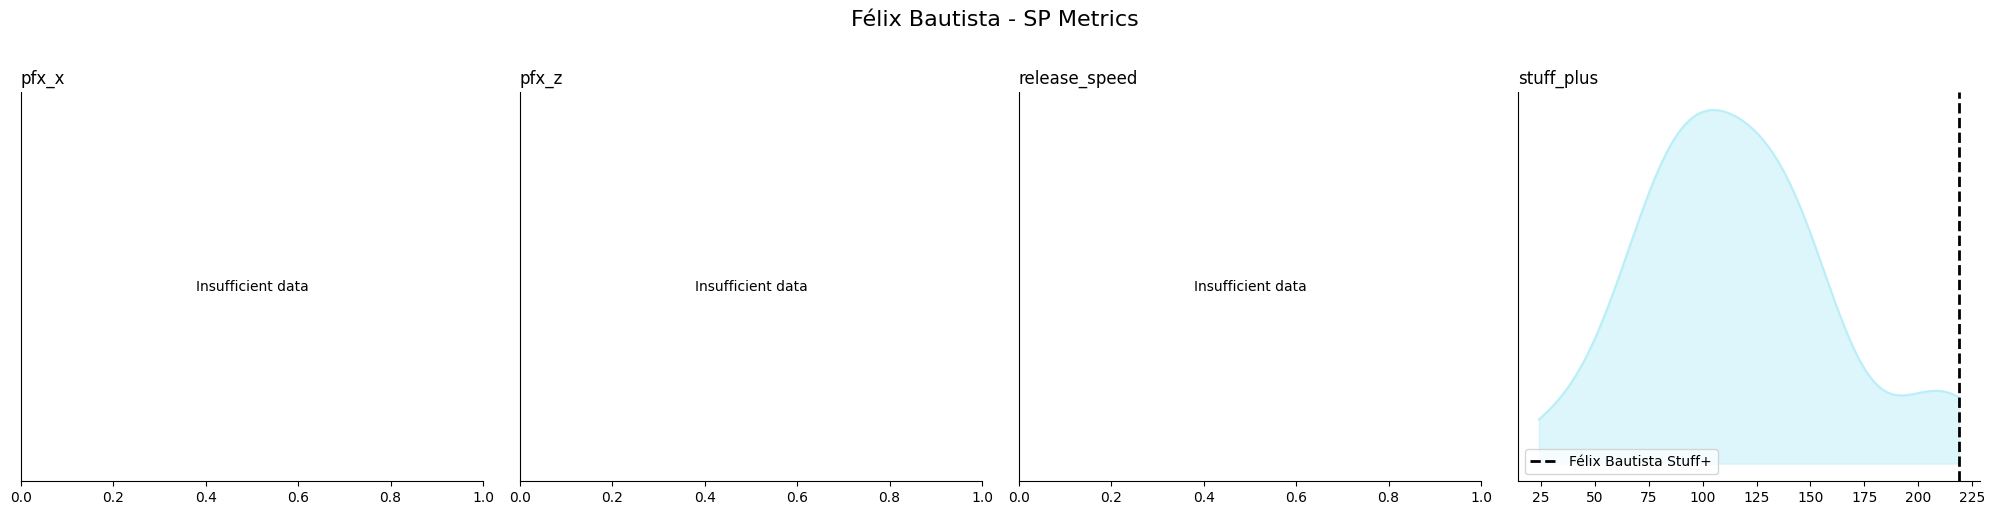

In [114]:
arsenal_hist('Félix Bautista', 'SP', df, stuff)

In [79]:
print(df['pfx_z'].isnull().sum())
print(df['pfx_x'].isnull().sum())

print(df['release_speed'].isnull().sum())
print(df['release_speed'].dtype)
print(df['pfx_x'].dtype)
print(df['pfx_z'].dtype)


0
0
0
Float64
float64
Float64


In [80]:
print(df['pfx_z'].nunique())
print(df['release_speed'].nunique())

430
683


In [81]:
len(df)

717653

In [82]:
print(df['release_speed'].unique())

<FloatingArray>
[89.0, 96.9, 90.0, 82.2, 89.2, 96.2, 88.2, 95.7, 79.4, 82.9,
 ...
 35.8, 33.4, 59.2, 55.4, 55.0, 45.0, 59.7, 51.2, 49.2, 60.5]
Length: 683, dtype: Float64


In [83]:
print(df['pfx_z'].unique())

<FloatingArray>
[ 0.33,  1.36,  0.36,  0.28,  0.31,   1.4,  0.43,   1.3,  -0.2,  0.01,
 ...
  2.11,   2.1,  2.14,  2.17,  2.84,  2.16,  2.46,  2.45,   2.5, -1.98]
Length: 430, dtype: Float64


In [94]:
stuff.head()

,Unnamed: 0,player_name,pitch_type,stuff_plus,count
0,1,Félix Bautista,SP,219,244
1,2,Jhoan Duran,SP,211,292
2,3,Shintaro Fujinami,SP,210,280
3,4,Kyle Finnegan,SP,207,272
4,5,Framber Valdez,CH,173,513


Index(['Unnamed: 0', 'player_name', 'pitch_type', 'stuff_plus', 'count'], dtype='object')
Félix Bautista's stuff_plus for SP: 219


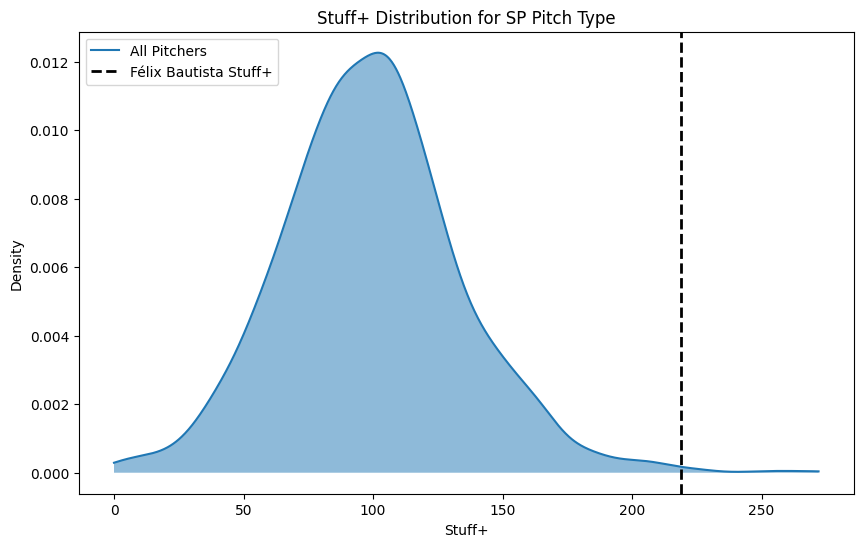

In [98]:
def plot_stuff_plus(player_name, pitch_type, original_df, stuff_df):
    print(stuff_df.columns)  # Diagnostic print
    
    # Filter the new DataFrame for the specific player and pitch type
    player_data = stuff_df[(stuff_df['player_name'] == player_name) & (stuff_df['pitch_type'] == pitch_type)]
    
    # Get the stuff_plus value for the given player
    if not player_data.empty:
        player_stuff_plus = player_data['stuff_plus'].iloc[0]
        print(f"{player_name}'s stuff_plus for {pitch_type}: {player_stuff_plus}")  # Diagnostic print
    else:
        print(f"No data for player {player_name} with pitch type {pitch_type} found.")
        return
    
    # Create histogram for stuff_plus across all players for the pitch type
    plt.figure(figsize=(10, 6))
    
    # Plot the distribution of stuff_plus
    all_stuff_plus = stuff_df['stuff_plus'].dropna().to_numpy(dtype=float)
    if all_stuff_plus.size > 1:
        kde = gaussian_kde(all_stuff_plus)
        x_grid = np.linspace(all_stuff_plus.min(), all_stuff_plus.max(), 1000)
        plt.fill_between(x_grid, kde(x_grid), alpha=0.5)
        plt.plot(x_grid, kde(x_grid), label='All Pitchers')
    
        # Highlight the given player's stuff_plus value
        plt.axvline(player_stuff_plus, color='black', linestyle='dashed', linewidth=2, label=f'{player_name} Stuff+')
        plt.legend()
    
        plt.title(f'Stuff+ Distribution for {pitch_type} Pitch Type')
        plt.xlabel('Stuff+')
        plt.ylabel('Density')
        plt.show()
    else:
        print("Insufficient data to plot KDE for stuff_plus.")

# Assuming you have the original DataFrame loaded as `df`
plot_stuff_plus('Félix Bautista', 'SP', df, stuff)


In [115]:
df.loc[df['player_name'] == 'Félix Bautista'].head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
3108,FF,2023-08-25,102.3,0.54,6.89,Félix Bautista,669911,642585,None,ball,...,5,4,5,4,5,Infield shade,Standard,186,0.0,0.016
3227,FF,2023-08-25,100.6,0.21,6.87,Félix Bautista,669911,642585,None,swinging_strike,...,5,4,5,4,5,Infield shade,Standard,184,0.0,-0.027
3366,FS,2023-08-25,91.3,-0.07,6.76,Félix Bautista,669911,642585,None,ball,...,5,4,5,4,5,Infield shade,Standard,220,0.0,0.012
3460,FF,2023-08-25,101.5,0.33,6.86,Félix Bautista,669911,642585,None,called_strike,...,5,4,5,4,5,Infield shade,Standard,187,0.0,-0.017
3577,FF,2023-08-25,101.3,0.06,6.81,Félix Bautista,605612,642585,field_out,hit_into_play,...,5,4,5,4,5,Standard,Standard,192,0.052,-0.194
